<a href="https://colab.research.google.com/github/tablehan/deepLearningPractice/blob/main/GRUforCCI30_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import math
#import pandas_datareader as web
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU, Dropout
import matplotlib.pyplot as plt
import time
import datetime
import os
print(os.path.abspath(''))

/content


In [2]:
# 從網路直接抓cci30過來測試建模
df=pd.read_csv("https://cci30.com/ajax/getIndexHistory.php",index_col=0).iloc[::-1,:]
print(df.shape)
# 空值處理
print(df.isnull().sum())
print(df[df["Volume"].isnull()])
# 取前後兩日差平均差補
df.loc['2020-11-30','Volume']=(df.loc['2020-12-01','Volume']+df.loc['2020-11-29','Volume'])/2
print(df.loc[['2020-11-29','2020-11-30','2020-12-01'],:])
# 排除成交量為0者
# exclude periods that valume=0
df=df[df['Volume']>0]
print(df.shape)

(2854, 5)
Open      0
High      0
Low       0
Close     0
Volume    1
dtype: int64
               Open     High      Low   Close  Volume
Date                                                 
2020-11-30  6327.62  6807.17  6270.84  6746.8     NaN
               Open     High      Low    Close        Volume
Date                                                        
2020-11-29  6270.79  6498.38  6133.79  6407.27  9.380875e+10
2020-11-30  6327.62  6807.17  6270.84  6746.80  1.127981e+11
2020-12-01  6748.96  6899.90  6220.79  6394.38  1.317874e+11
(1699, 5)


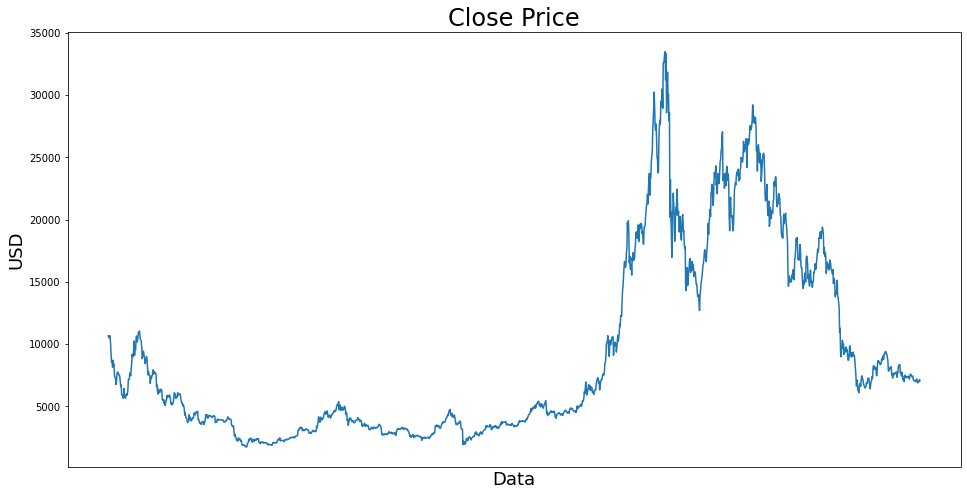

In [3]:
plt.figure(figsize=(16,8))
plt.title('Close Price', fontsize=24)
plt.plot(df['Close'])
plt.xticks([])
plt.xlabel('Data', fontsize=18)
plt.ylabel('USD', fontsize=18)
plt.show()

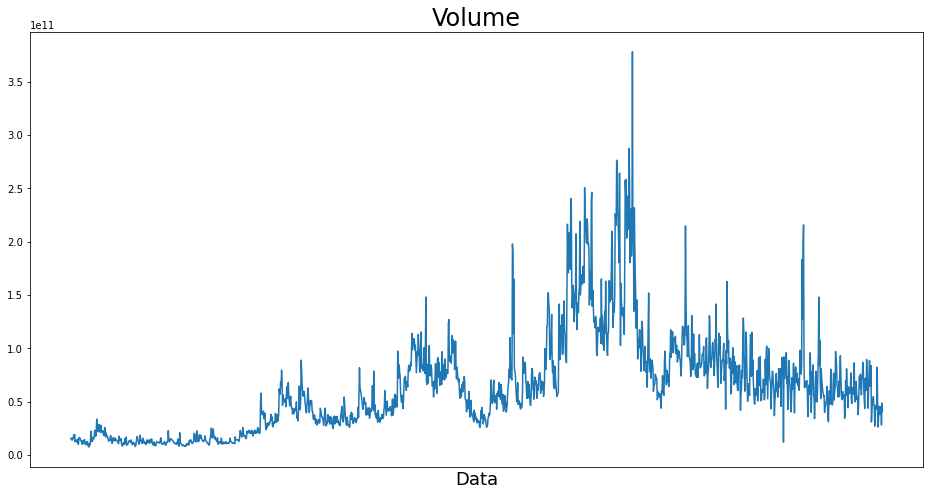

In [4]:
plt.figure(figsize=(16,8))
plt.title('Volume', fontsize=24)
plt.plot(df['Volume'])
plt.xticks([])
plt.xlabel('Data', fontsize=18)
plt.show()

In [5]:
# Get the number of rows to train the model on. we need this number to create our train and test sets
# math.ceil will round up the number
training_data_len = math.ceil(df.shape[0] * .8) # We are using %80 of the data for training
training_data_len

1360

In [6]:
# Scale the data with MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(df)
print(scaled_data)

[[0.26718113 0.27445008 0.28023588 0.28102918 0.02205259]
 [0.28119915 0.27450425 0.28790962 0.27647164 0.0224575 ]
 [0.27647607 0.27319202 0.28864061 0.27661967 0.0184771 ]
 ...
 [0.1644447  0.1582786  0.17600956 0.16549683 0.05578381]
 [0.165556   0.16302459 0.17659601 0.17091833 0.11112113]
 [0.17098645 0.16331592 0.17848203 0.16727702 0.08984366]]


In [7]:
# hyper param
timeStep=10
batch_size=4
epochs=100
d=0.2

In [8]:
# Creat the training dataset
train_data = scaled_data[0:training_data_len, :]

#Split the data into X_train and y_train data sets
X_train = np.array([train_data[i-timeStep:i,:] for i in range(timeStep, len(train_data))])
y_train = np.array([train_data[i,:] for i in range(timeStep, len(train_data))])
print(f'X_train shape:{X_train.shape}',f'y_train_shape: {y_train.shape}')

X_train shape:(1350, 10, 5) y_train_shape: (1350, 5)


In [9]:
# Create the testing dataset
# Create a new array containing scaled values from index 1335
test_data = scaled_data[training_data_len - timeStep : , :]
test_data
X_test = np.array([test_data[i-timeStep: i,:] for i in range(timeStep,len(test_data))])
y_test = np.array([test_data[i,:] for i in range(timeStep, len(test_data))])
print(f'X_test shape:{X_test.shape}',f'y_test_shape: {y_test.shape}')

X_test shape:(339, 10, 5) y_test_shape: (339, 5)


In [10]:
# Build LSTM model
tf.random.set_seed(42)
model_1 = Sequential()
model_1.add(GRU(64, return_sequences=True, input_shape=(timeStep, X_train.shape[-1])))
model_1.add(Dropout(d))
model_1.add(GRU(64, return_sequences=False))
model_1.add(Dropout(d))
model_1.add(Dense(32))
model_1.add(Dense(5))

In [11]:
# Compile the model
model_1.compile(optimizer='adam', loss='mse')
print(model_1.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 10, 64)            13632     
                                                                 
 dropout (Dropout)           (None, 10, 64)            0         
                                                                 
 gru_1 (GRU)                 (None, 64)                24960     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 5)                 165       
                                                                 
Total params: 40,837
Trainable params: 40,837
Non-traina

In [12]:
# Train the model
start_fix_time=datetime.datetime.now()
print(start_fix_time)
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)
history = model_1.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=2, validation_data=(X_test,y_test))

end_fix_time=datetime.datetime.now()
print(end_fix_time)

2022-10-26 07:01:20.176455
Epoch 1/100
338/338 - 12s - loss: 0.0049 - val_loss: 0.0014 - 12s/epoch - 34ms/step
Epoch 2/100
338/338 - 2s - loss: 0.0022 - val_loss: 0.0015 - 2s/epoch - 5ms/step
Epoch 3/100
338/338 - 2s - loss: 0.0021 - val_loss: 0.0022 - 2s/epoch - 5ms/step
Epoch 4/100
338/338 - 2s - loss: 0.0018 - val_loss: 0.0011 - 2s/epoch - 5ms/step
Epoch 5/100
338/338 - 2s - loss: 0.0017 - val_loss: 0.0011 - 2s/epoch - 5ms/step
Epoch 6/100
338/338 - 2s - loss: 0.0017 - val_loss: 0.0058 - 2s/epoch - 5ms/step
Epoch 7/100
338/338 - 2s - loss: 0.0017 - val_loss: 9.1580e-04 - 2s/epoch - 5ms/step
Epoch 8/100
338/338 - 2s - loss: 0.0016 - val_loss: 0.0017 - 2s/epoch - 5ms/step
Epoch 9/100
338/338 - 2s - loss: 0.0016 - val_loss: 9.0637e-04 - 2s/epoch - 5ms/step
Epoch 10/100
338/338 - 2s - loss: 0.0015 - val_loss: 0.0011 - 2s/epoch - 5ms/step
Epoch 11/100
338/338 - 2s - loss: 0.0014 - val_loss: 0.0021 - 2s/epoch - 5ms/step
Epoch 12/100
338/338 - 2s - loss: 0.0015 - val_loss: 0.0012 - 2s/epoc

<function matplotlib.pyplot.show(*args, **kw)>

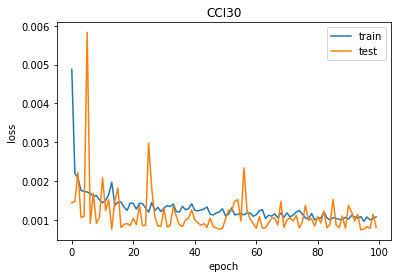

In [13]:
# plot the loss graph
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('CCI30',fontsize='12')
plt.ylabel('loss',fontsize='10')
plt.xlabel('epoch',fontsize='10')
plt.legend()
plt.show

In [14]:
# Get the model_1 predicted price values 
predictions_1 = model_1.predict(X_test)
predictions_1 = scaler.inverse_transform(predictions_1)
predictions_1[:5,:]

11/11 [==============================] - 1s 3ms/step


array([[2.4982301e+04, 2.5964287e+04, 2.4288230e+04, 2.4938010e+04,
        7.8646559e+10],
       [2.5446709e+04, 2.6360338e+04, 2.5022145e+04, 2.5386744e+04,
        6.5853751e+10],
       [2.5182617e+04, 2.6158859e+04, 2.4664373e+04, 2.5189357e+04,
        7.7239493e+10],
       [2.4591938e+04, 2.5542814e+04, 2.4106352e+04, 2.4594287e+04,
        6.9780201e+10],
       [2.4937609e+04, 2.5907080e+04, 2.4381049e+04, 2.4949213e+04,
        8.0154976e+10]], dtype=float32)

In [17]:
#plotting param
dic={0:"Open",1:"High",2:"Low",3:"Close",4:"Volume"}
nums=0

In [18]:
# measure
from sklearn.metrics import mean_squared_error, r2_score
y_inver=scaler.inverse_transform(y_test)
for i in dic.keys():
  MSE=mean_squared_error(predictions_1[i], y_inver[i])
  R2=r2_score(predictions_1[i], y_inver[i])
  print(f'{dic[i]}: Mean Squre Error={MSE} , | R2={R2}')
MSE=mean_squared_error(predictions_1, y_inver)
R2=r2_score(predictions_1, y_inver)
print(f'Total: Mean Squre Error={MSE} , | R2={R2}')

Open: Mean Absolute Error=2.628275984210918e+19 , | R2=0.9734422167175918
High: Mean Absolute Error=2.4798194876072366e+19 , | R2=0.9642612473717278
Low: Mean Absolute Error=1.1347695727029455e+19 , | R2=0.9881119903718795
Close: Mean Absolute Error=7.464422252032539e+19 , | R2=0.9041897317526021
Volume: Mean Absolute Error=1.2848450651969989e+19 , | R2=0.9875011497349033
Total: Mean Absolute Error=8.605744832456534e+19 , | R2=0.5499268830712131


Text(0.5, 0, 'epochs')

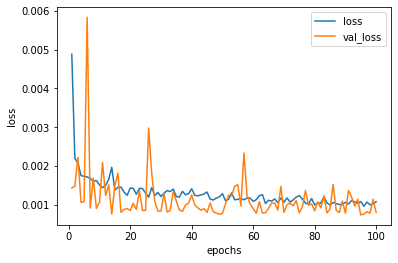

In [19]:
# Let's plot the history of model_1 and see what's going on
historyForPlot = pd.DataFrame(history.history)
historyForPlot.index += 1 # we plus 1 to the number of indexing so our epochs Plot picture will be counting from 1 not 0.
historyForPlot.plot()
plt.ylabel("loss")
plt.xlabel("epochs")

In [ ]:
# reference
# https://github.com/Ali619/Bitcoin-Price-Prediction-LSTM/blob/master/Bitcoin_Price_Prediction.ipynb

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


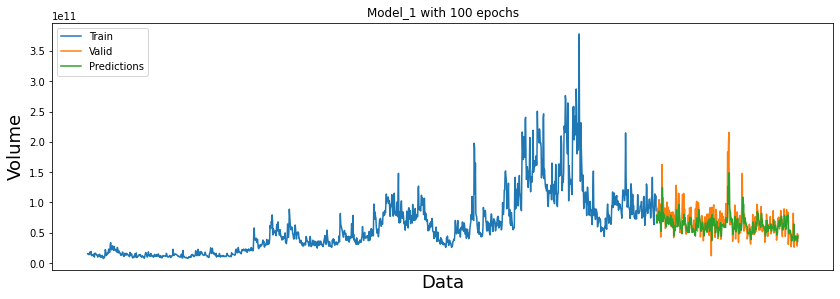

In [22]:
# Plot the data
nums=4
train = df.iloc[:training_data_len]
# data for model_1
valid_1 = df.iloc[training_data_len:,:]
valid_1['Predictions'] = predictions_1[:,nums]

plt.figure(figsize=(14, 10))
plt.subplot(2, 1, 1)
plt.title(f'Model_1 with {epochs} epochs')
plt.xticks([])
plt.xlabel('Data', fontsize=18)
plt.ylabel(f'{dic[nums] if nums==4 else dic[nums]+" Price(USD)"}', fontsize=18)
plt.plot(train[dic[nums]])
plt.plot(valid_1[[dic[nums],"Predictions"]])
plt.legend(['Train', 'Valid', 'Predictions'], loc='upper left')

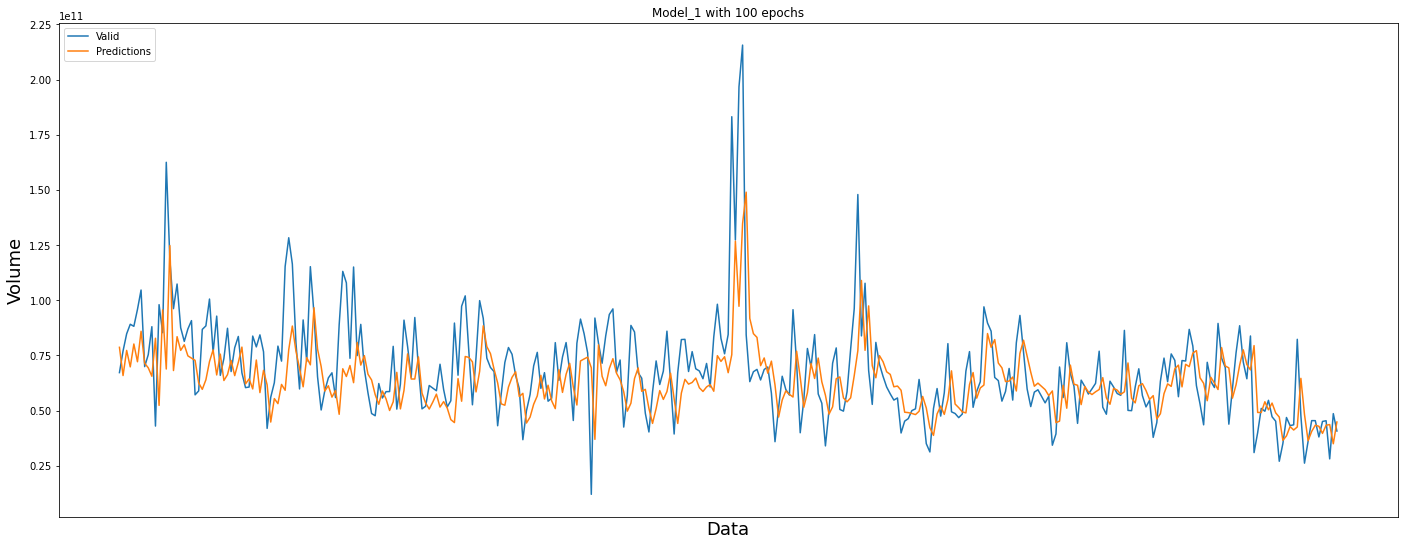

In [23]:
plt.figure(figsize=(24, 20))
plt.subplot(2, 1, 1)
plt.title(f'Model_1 with {epochs} epochs')
plt.xticks([])
plt.xlabel('Data', fontsize=18)
plt.ylabel(f'{dic[nums] if nums==4 else dic[nums]+" Price(USD)"}', fontsize=18)
plt.plot(valid_1[[dic[nums],"Predictions"]])
plt.legend(['Valid', 'Predictions'], loc='upper left')

In [ ]:
 model_1.save('models_GRU/bdse27_lstm_model.h5')

In [ ]:
# 建構最後一個X作為預測新值的開始
last_data = df[-timeStep:]
last_date = datetime.datetime.strptime(last_data.index[-1],"%Y-%m-%d")
print(last_date)
future_periods=100

for _ in range (future_periods):
  #print(last_data.iloc[-1,:])
  pred_data=last_data[-timeStep:]

# Scale the data to be values between 0 and 1
  pred_data_scaled = scaler.fit_transform(pred_data.values)

  new_X_test = np.array(pred_data_scaled).reshape(1,pred_data_scaled.shape[0],pred_data_scaled.shape[1])

  pred_ = model_1.predict(new_X_test)
# Undo the scaling
  pred = scaler.inverse_transform(pred_)
  last_date = last_date + datetime.timedelta(days=1)
  pred = pd.DataFrame(pred,
        columns= ["Open","High","Low","Close","Volume"],
        index =["*"+datetime.datetime.strftime(last_date,"%Y-%m-%d")]
        )
  last_data=pd.concat([last_data,pred],axis=0)
print(last_data)

2022-10-03 00:00:00
                    Open         High          Low        Close        Volume
2022-09-24   7509.820000  7647.160000  7332.200000  7386.420000  4.381290e+10
2022-09-25   7386.230000  7546.360000  7220.370000  7308.520000  6.020709e+10
2022-09-26   7309.390000  7472.790000  7170.730000  7383.250000  7.613303e+10
2022-09-27   7383.370000  7725.250000  7190.130000  7304.550000  8.843916e+10
2022-09-28   7302.270000  7449.250000  7043.160000  7345.710000  7.199413e+10
...                  ...          ...          ...          ...           ...
*2023-01-07  7376.643066  7515.360352  7138.226562  7378.008789  4.579570e+10
*2023-01-08  7376.643066  7515.356934  7138.226562  7378.008789  4.579570e+10
*2023-01-09  7376.642578  7515.353516  7138.226562  7378.008789  4.579570e+10
*2023-01-10  7376.641602  7515.350098  7138.226562  7378.008789  4.579570e+10
*2023-01-11  7376.641113  7515.347168  7138.226562  7378.008789  4.579570e+10

[110 rows x 5 columns]
